Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 05: Eye tracking

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 28, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

For this exercise sheet you will have 2 weeks and the sheet is also worth of 30 points. In this exercise sheet you will start to work with eye tracking data. Note that the data we will use here are not raw gaze data and contain coordinates of fixation points.

The dataset is distributed freely by a following study: [Wilming, N. Dryad](https://www.nature.com/articles/sdata2016126#data-citations). By clicking on the link in the section "Data Citations" you will get redirected to the page where you can download all the data openly distributed. Read below for description of each file.

##### necessary
*etdb_v1.0*: This is the main data file. The hdf5 file consists of all the fixation data and the metadata.  
*Read gaze data with python*: Python script to read hdf5 file as a dataframe.  
*Stimuli/i*: Zip file containing image stimuli used in the study. The encoding convention is same as in the dataframe.
##### optional
*Metadata*: This is the csv file giving overview of all studies.

In [2]:
%pip install h5py # make sure to install h5py which is used in fixmat.py


The following command must be run outside of the IPython shell:

    $ pip install h5py # make sure to install h5py which is used in fixmat.py

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more informations on how to install packages:

    https://docs.python.org/3/installing/


In [79]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
#from statsmodels.stats.anova import *
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from fixmat import *

## Assignment 0: Peer review for sheet 04 [3 pts]

Each group reviews the solutions of two other groups and give points according to the given point distribution considering the correctness of the solution. For this reviews the tutors will give you up to 3 points each week. Follow a distributed comment guidelines if you are unsure.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 5, 9 | 1, 6  | 4, 7  | 7, 2 | 2, 11 | 8, 3 | 3, 10  | 11, 1  | 10, 4  | 6, 8  | 9, 5   |


## Assignment 1: Checking the data distribution [9 pts]

### a) loading datasets [0 pts]
As with any other datasets, the first step is to get an idea of the dataset. Check the meta data and column of the dataframe.

In [80]:
# use a fixmat.py to load the hdf5 format data as a panda dataframe
df, meta = load('etdb_v1.0.hdf5', "Baseline")
df.head()

,SUBJECTINDEX,category,dataset_nr,end,eye,filenumber,fix,pupil,start,trial,x,y
0,1.0,11.0,3.0,215.0,2.0,25.0,1.0,3287.901123,-183.0,1.0,636.0,489.0
1,1.0,11.0,3.0,503.0,2.0,25.0,2.0,2872.182129,261.0,1.0,524.0,276.0
2,1.0,11.0,3.0,819.0,2.0,25.0,3.0,2452.396484,541.0,1.0,592.0,393.0
3,1.0,11.0,3.0,1103.0,2.0,25.0,4.0,2135.433594,865.0,1.0,367.0,339.0
4,1.0,11.0,3.0,1399.0,2.0,25.0,5.0,2007.327393,1145.0,1.0,196.0,364.0


In [81]:
meta

{'# Fix.': 203772,
 '# Obs.': 48,
 'Age': '23.1 (19-28)',
 'Article': 15.0,
 'Categories': '7,8,10,11',
 'Disp. Size (degree)': '29x22',
 'Display': 'SM1100',
 'Display resolution (pixels)': '1280x960',
 'Eye Tracker': 'EL II',
 'ID': 3,
 'Img. Pos. (pixel)': '0,0',
 'Img. size (pixel)': '1280x960',
 'PPD': 45.600000000000001,
 'Sampling freq. (Hz)': '500 Hz',
 'Task': 'FV',
 'V. Dur.': '6s',
 'V. dist. (cm) ': 80,
 'Val. error (degrees)': 0.29999999999999999}

In [82]:
df.columns

Index(['SUBJECTINDEX', 'category', 'dataset_nr', 'end', 'eye', 'filenumber',
       'fix', 'pupil', 'start', 'trial', 'x', 'y'],
      dtype='object')

### b) data cleaning [3 pts]
We want to clean the dataframe so that it is handy for us to work with it.
- How many fixations do we have per category? ```agg``` function might be helpful.
- categories are encoded using a number. Add a column to the dataframe that has approporiate string value for that category (e.g. code 11.0 to "Pink-noise"). The category names can be found on Figure 2 of the paper.
- since measurements lasted for 6 seconds, any fixation points that have a onset time before 0 sec and end time more than 6 sec are erroneous. Remove these rows.
- also remove all rows with any NaN values.
- add a column called ```duration``` and compute the duration of each fixation.
- It is known from previous literature that fixations typically last between 100 msec to 400 msec. Remove all rows with unrealistic  fixation duration.
- check how many data points got removed for each category. Let's hope that we didn't delete too many rows from a single category.
- count the number of fixations for each trial. To do this, you can use the aggregate method to count the number of rows for each category.
- print the mean duration and the mean number of fixation across all trials. Are they in a realistic range?

In [83]:
fix_cat = df['category'].agg('value_counts', axis=0)  # fixations per category
#print(fix_cat)

categories = {7:'Natural', 8:'Urban', 10:'Fractals', 11:'Pink-noise'}  # map numbers to category names
df['category name'] = df['category'].map(categories)  # add a column with string names of categories
df = df[(df['start'] >= 0) & (df['end'] <= 6000)]  # remove fixations with onset before 0 sec or end time after 6 sec
df = df.dropna() # remove NaN
df['duration'] = df['end'] - df['start']  # add column duration
df = df[(df['duration'] >= 100) & (df['duration'] <= 400)]  # remove fixations shorter than 100 ms or longer than 4 ms

fix_cat = df['category'].agg('value_counts', axis=0)  # fixations per category
#print(fix_cat)
fix_trial = df.groupby('SUBJECTINDEX')['trial'].agg('value_counts')  # fixations per subject per trial
#print(fix_trial)
print('Mean duration: {:.2f} msec'.format(df['duration'].mean()))
print('Mean number of fixations across all trials: {:.0f}'.format(fix_trial.mean()))
df

Mean duration: 240.49 msec
Mean number of fixations across all trials: 13


,SUBJECTINDEX,category,dataset_nr,end,eye,filenumber,fix,pupil,start,trial,x,y,category name,duration
1,1.0,11.0,3.0,503.0,2.0,25.0,2.0,2872.182129,261.0,1.0,524.0,276.0,Pink-noise,242.0
2,1.0,11.0,3.0,819.0,2.0,25.0,3.0,2452.396484,541.0,1.0,592.0,393.0,Pink-noise,278.0
3,1.0,11.0,3.0,1103.0,2.0,25.0,4.0,2135.433594,865.0,1.0,367.0,339.0,Pink-noise,238.0
4,1.0,11.0,3.0,1399.0,2.0,25.0,5.0,2007.327393,1145.0,1.0,196.0,364.0,Pink-noise,254.0
6,1.0,11.0,3.0,2263.0,2.0,25.0,7.0,2346.299316,1977.0,1.0,687.0,356.0,Pink-noise,286.0
7,1.0,11.0,3.0,2595.0,2.0,25.0,8.0,2303.531250,2301.0,1.0,823.0,285.0,Pink-noise,294.0
8,1.0,11.0,3.0,2907.0,2.0,25.0,9.0,2606.652344,2637.0,1.0,688.0,238.0,Pink-noise,270.0
10,1.0,11.0,3.0,3563.0,2.0,25.0,11.0,2309.188965,3433.0,1.0,469.0,380.0,Pink-noise,130.0
11,1.0,11.0,3.0,4083.0,2.0,25.0,12.0,2646.744385,3717.0,1.0,534.0,431.0,Pink-noise,366.0
12,1.0,11.0,3.0,4279.0,2.0,25.0,13.0,2757.007324,4101.0,1.0,542.0,414.0,Pink-noise,178.0


Before data cleaning: <br>
Urban: 56680 fixations <br>
Fractals: 52901 fixations<br>
Natural: 52338 fixations <br>
Pink-noise: 41853 fixations <br>
Total: 203772 <br><br>
After data cleaning: <br>
Urban: 44845 <br>
Fractals: 39922 <br>
Natural: 39784 <br>
Pink-noise: 27250 <br>
Total: 151801 <br><br>
A mean duration of 240.49 msec is in a realistic range, since we are only considering fixations lasting between 100 and 400 msec. A mean of 13 fixations per trial across all trials and all subjects makes sense as well, since we have 255 trials and 48 subjects, which makes 159120 fixations in total, compared to 151801 actual fixations ($13*255*48=159120$).

### c) visualizing data distribution [3 pts]
Are there any inter-subject difference and effect of different category in our data?
- plot the mean duration for each category (4 x-values) and the mean duration for each subject (48 x-values).

- plot the mean number of fixations for each category (4 x-values) and the mean number of fixation for each subject (48 x-values).

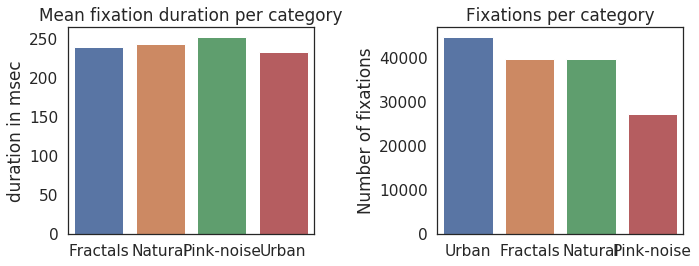

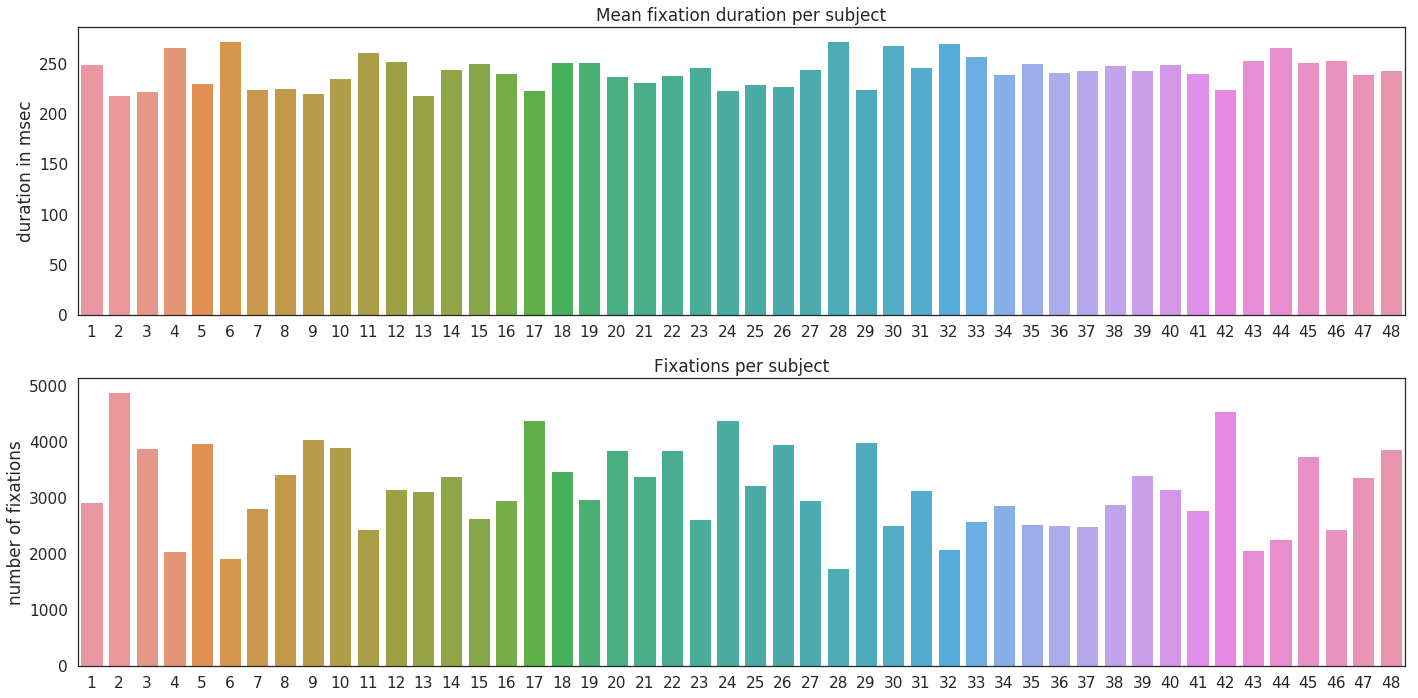

In [148]:
%matplotlib inline

duration_category = df.groupby('category name')['duration'].mean()  # mean fixation duration per category
duration_subjects = df.groupby('SUBJECTINDEX')['duration'].mean()  # mean fixation duration per subject
fixation_category = df['category name'].agg('value_counts', axis=0)  # number of fixations per category
fixation_subjects = df['SUBJECTINDEX'].agg('value_counts', axis=0)  # number of fixations per subject

sns.set(context='notebook', style='white', font_scale=1.4)

fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
bar_dur_cat = sns.barplot(x=duration_category.keys(), y=duration_category.get_values(), ax=axes1[0])
bar_fix_cat = sns.barplot(x=fixation_category.keys(), y=fixation_category.get_values(), ax=axes1[1])
bar_dur_cat.set(title='Mean fixation duration per category', ylabel='duration in msec', xlabel='')
bar_fix_cat.set(title='Fixations per category', ylabel='Number of fixations')
fig1.tight_layout()

subject_id = np.arange(1,49)  # custom xticklabels instead of float subject id

fig2, axes2= plt.subplots(nrows=2, ncols=1, figsize=(20,10))
bar_dur_sub = sns.barplot(x=duration_subjects.keys(), y=duration_subjects.get_values(), ax=axes2[0])
bar_fix_sub = sns.barplot(x=fixation_subjects.keys(), y=fixation_subjects.get_values(), ax=axes2[1])
bar_dur_sub.set(title='Mean fixation duration per subject', ylabel='duration in msec', xlabel='', xticklabels=subject_id)
bar_fix_sub.set(title='Fixations per subject', ylabel='number of fixations', xticklabels=subject_id)
fig2.tight_layout()

Question: It says "plot the **mean** number of fixations for each category (...)", Mean with regard to what? Do you mean the the mean of fixations per trial per category and the mean of fixations per trial per subject respectively? The plots above display the number of fixations per conditon and the number of fixations per subject respectively, since it is unclear to me which mean you are referring to in this context.

### d) normally distributed data [3 pts]
As ANOVA and lots of other statistical tests can be used only for normally distributed varaibles, it makes sense to find out whether the fixation duration and the number of fixations per trial is also normally distributed. This can be done with a Q-Q-Plot, which  is a graphical technique for determining if two data sets come from populations with a common distribution, in this case a normal distribution (for more information, klick [here](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33o.htm)).
- make a Q-Q plot of the variable *fixation duration*. Is it approximately normally distributed?
- make a Q-Q plot of the variable *# fixation per trial*. Is it approximately normally distributed?

/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


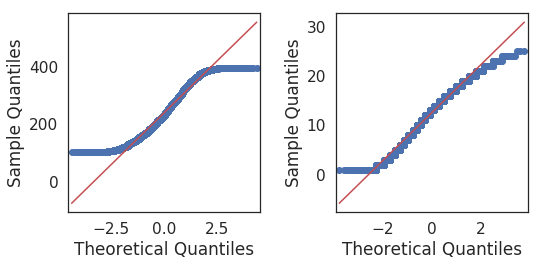

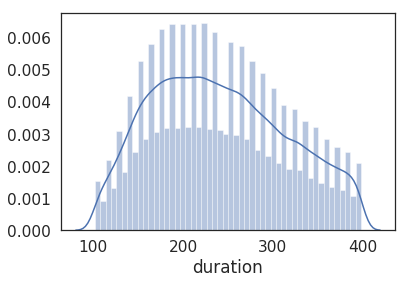

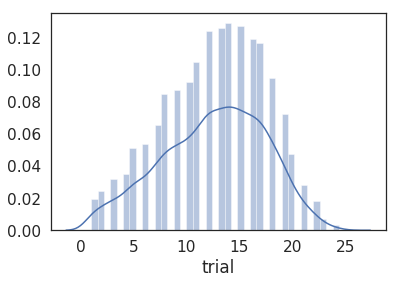

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
qq_duration = sm.ProbPlot(df['duration'], dist='norm')  # Q-Q plot of fixation duration - normal distribution
qq_duration.qqplot(line='r', ax=axes[0])
qq_fix = sm.ProbPlot(fix_trial, dist='norm')  # Q-Q plot of number of fixations per trial - normal distribution
qq_fix.qqplot(line='r', ax=axes[1])
fig.tight_layout()
fig.show()

figure = plt.figure()
sns.distplot(df['duration'])  # for comparison: probability density function of duration
figure.show()

figure = plt.figure()
sns.distplot(fix_trial)  # for comparison: probability density function of number of fixations per trial
figure.show()

*Fixation duration:* Just by looking at the Q-Q plot, it seems like fixation duration is a symmetric Gaußian distribution with greater standard deviation compared to a standard normal distribution. However, the pdf reveals that fixation duration does not only have a greater std but it is also slightly skewed to the right. <br><br>
*Number of fixations per trial:* The Q-Q plot suggest that the distribution of number of fixations per trial is a slightly leftwards skewed normal distribution. The pdf plot confirms the initial suggestion. <br><br>
Overall, fixation duration and number of fixations per trial are approcimately normally distributed.

## Assignment 2: Hypothesis testing [3 pts]

### a) one way ANOVA [3 pts]
Now it's time to really prove our intuition. Test the following null hypotheses:  
$H01$: There is no difference in fixation duration across 4 different categories.  
$H02$: There is no difference in the number of fixations across 4 different categories.

What do you find?

In [87]:
# H01
#duration_category_subject = df.groupby(["SUBJECTINDEX", "category"]).agg({"duration": "mean"})
#duration_category_subject.reset_index(inplace=True)

#model = ols("duration ~ category", data=duration_category_subject).fit()
#anova_lm(model, typ=1)

# H01
lm = ols("duration ~ category", data = df).fit()  # model fitting one-way ANOVA
table = anova_lm(lm, type=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
category,1.0,1.330038e+06,1.330038e+06,246.995531,1.298364e-55
Residual,151799.0,8.174172e+08,5.384865e+03,NaN,NaN


In [88]:
# H02
#fixations_category_subject = df.groupby(["SUBJECTINDEX", "category"]).agg({"fix": "max"})
#fixations_category_subject.reset_index(inplace=True)

#model = ols("fix ~ category", data=fixations_category_subject).fit()
#anova_lm(model, type=1)

# H02
category_fixations = df['category'].agg('value_counts').reset_index()  # compute number of fixations per category
category_fixations = category_fixations.rename(columns={'index' : 'category', 'category' : 'fixations'})

lm = ols("fixations ~ category", data=category_fixations).fit()  # model fitting one-way ANOVA
table = anova_lm(lm, type=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
category,1.0,89946008.10,8.994601e+07,2.267431,0.271073
Residual,2.0,79337356.65,3.966868e+07,NaN,NaN


What do you say? <br>
* We reject H01, because there is a significant difference in fixation duration across the 4 different categories. <br>
* We do not reject H02, because there is no significant difference in the number of fixations acroos the 4 different categories.

## Assignment 3: Binning [4 pts]

### a) distribution of # fixation [2 pts]
Now we would like to know if there's a difference in terms of fixation numbers at different time segment.
- make a histogram with x axis being the start time of fixation
- the bin size should be 1 sec. In total there would be 6 bins.
- average over all subjects and images, just make a one simple plot
- figure out mean fixation duration for each bin and print it


Mean fixation duration for fixations starting between 0 and 1000 ms: 232.85 ms
Mean fixation duration for fixations starting between 1000 and 2000 ms: 242.94 ms
Mean fixation duration for fixations starting between 2000 and 3000 ms: 242.90 ms
Mean fixation duration for fixations starting between 3000 and 4000 ms: 243.20 ms
Mean fixation duration for fixations starting between 4000 and 5000 ms: 243.33 ms
Mean fixation duration for fixations starting between 5000 and 6000 ms: 236.73 ms


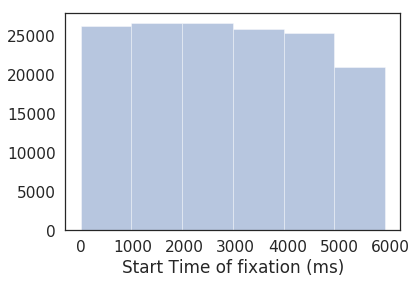

In [91]:
sns.distplot(df["start"], bins=6, kde=False, axlabel='Start Time of fixation (ms)')
for end in np.arange(1000, 6001, 1000):
    start = end - 1000
    mean_fixation = df[(df['start'] >= start) & (df['start'] <= end)]['duration'].mean()
    print('Mean fixation duration for fixations starting between {} and {} ms: {:.2f} ms'.format(start, end, mean_fixation))

### b) leftward bias [2 pts]
If you took Action & Cognition I, you have probably heard about the leftward bias in human's fixation behavior. It is known that people tend to look more at the left visual field for the initial first second. Check whether this holds for our dataset as well.
- make a pointplot with x-axis as the x-coordinate of each fixation point and y-axis as the time bin to which the fixation point belongs to.
- mark the confidence interval around each point.
- make a vertical line at middle point of the x values. The x-coordinate of the fixation point in the data is based on the coordinate system using the display resolution. You can find out the information about display resolution by taking a look at the meta data.

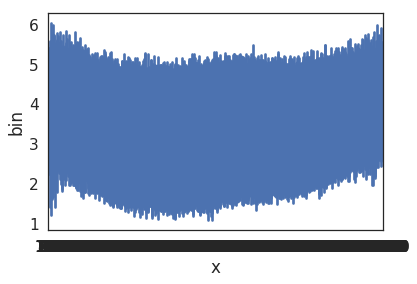

In [92]:
df['bin'] = (df['start'] // 1000) + 1  # add bins to data frame
sns.pointplot(data=df, x='x', y='bin', ci='sd')
#df.groupby('bin')['x'].mean()

## Assignment 4: Heatmap [4 pts]
Now let's use heatmap to visualize which part of pictures is fixated for how long. It would be also good to know if there's a difference between categories.
- make a heatmap for data consisting of each categories and then averaged across all data.
- mark a central point in the plot.
- you can use ```numpy.histogram2d``` to compute a bi-dimensional histogram.
- then you can use ```pyplot.imshow``` to plot these histogram.
- don't forget to use the parameter ```extent``` to control for the bounding box to which the image should fit in.
- if you want to use other functions that's surely fine as well.

(0.0, 20.0, 20.0, 0.0)

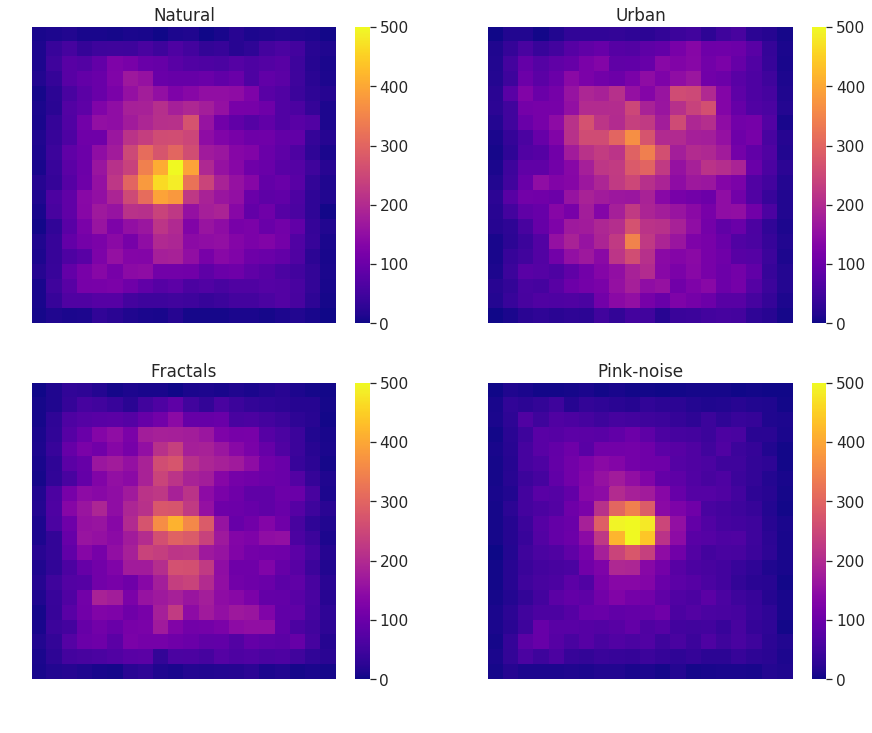

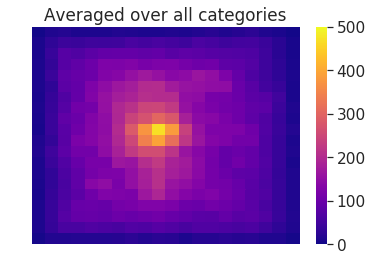

In [177]:
gb = df.groupby("category")
fig, axes = plt.subplots(2,2, figsize=(15, 12))
axes = axes.reshape(1,4)[0]
bins = 20
hm = np.zeros((4, bins, bins)) # matrices of the 4 heatmaps

# heatmaps for each category
for i, cat in enumerate(gb.groups):
    df_cat = gb.get_group(cat)
    hm[i] = np.histogram2d(df_cat["x"], df_cat["y"], bins=bins)[0]
    heat  = sns.heatmap(hm[i], center=250, vmin=0, vmax=500, cmap="plasma", ax=axes[i])
    heat.set(title=categories[cat])
    axes[i].set_xlabel("x")
    axes[i].axis("off")
    # TODO marking a central point in the plot
    
# heatmap averaged over categories (mean across hm)
fig = plt.figure()
heat = sns.heatmap(hm.mean(axis=0), center=250, vmin=0, vmax=500, cmap="plasma")
heat.set(title="Averaged over all categories")
fig.axes[0].axis("off")

## Assignment 5: Scanpath [5 pts]
We want to know whether different scan behaviour is used when viewing images of different categories. Scanpath is a path followed by the eyes when viewing a stimulus. Scanpaths are useful for analyzing cognitive intent, interest, and salience. It has an advantage to a heatmap because the information about temporal structure of viewing behaviour can be plotted.
- make four plots, one for each category.
- randomely choose one trial for which you will plot a scanpath.
- mark fixation points based on the x-y coordinates.
- plot the *saccade path* from one fixation point to another one.
- make sure that the order of fixation can be read out from the plot. E.g. earlier fixations could have a light color whereas later fixations could have dark colors.
- also include information about the duration of each fixation. One way to do it is the use the size of the fixation marker.
- plot the background image superimposed with the scanpath. 

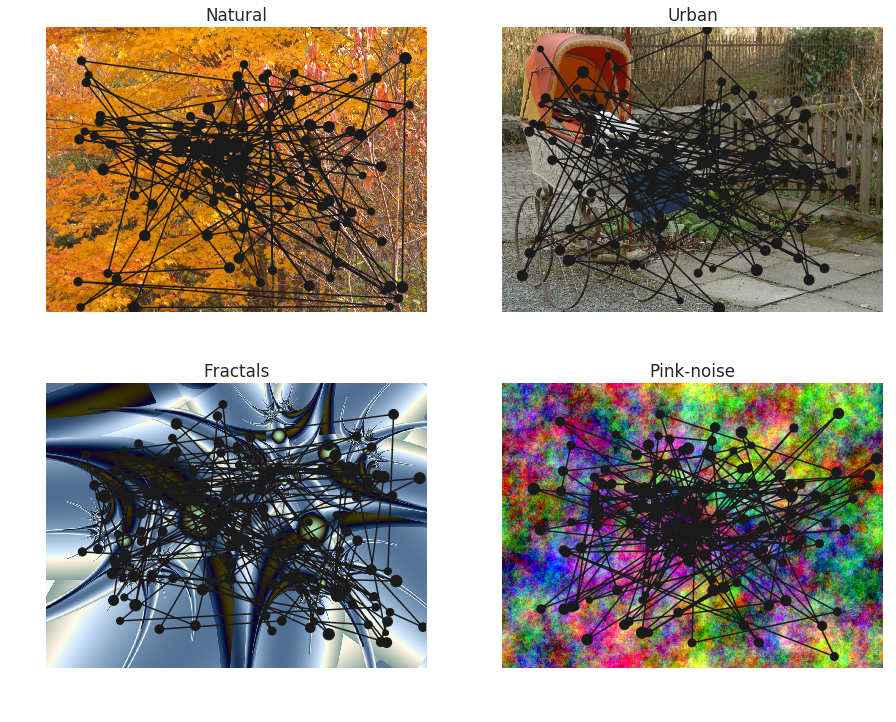

In [223]:
trial = 1
gb = df[df["trial"] == trial].sort_values("start").groupby("category")
fig, axes = plt.subplots(2,2, figsize=(15, 12))
axes = axes.reshape(1,4)[0]

for i, cat in enumerate(gb.groups):
    df_cat = gb.get_group(cat)
    axes[i].plot(df_cat["x"], df_cat["y"], '.k-') # draw lines
    axes[i].scatter(df_cat["x"], df_cat["y"], s=df_cat["duration"].apply(lambda x: x/3), c="k") # for markersize
    axes[i].imshow(plt.imread("{}.png".format(int(cat)))) # background image (for trial 1 respectively)
    axes[i].set_title(categories[cat])
    axes[i].set_xlabel("x")
    axes[i].axis("off")

# Citation
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) An extensive dataset of eye movements during viewing of complex images. Scientific Data 4: 160126. https://doi.org/10.1038/sdata.2016.126  
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) Data from: An extensive dataset of eye movements during viewing of complex images. Dryad Digital Repository. https://doi.org/10.5061/dryad.9pf75